<a href="https://colab.research.google.com/github/CadeHarger/portfolio/blob/main/Personal_Projects/Convert_StyleGAN2_to_CoreML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Setup
import tensorflow as tf

!git clone https://github.com/CadeHarger/ColabStyleGAN2.git --quiet

!python /content/ColabStyleGAN2/weights/download.py
!mv "/content/ffhq.npy" "/content/ColabStyleGAN2/weights/"
!mkdir /content/out

import sys
sys.path.insert(0, "/content/ColabStyleGAN2")

import argparse
import time
import math
import numpy as np
import PIL.Image
import re
import sys
import os
from google.colab import output as Output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
from utils.utils_stylegan2 import convert_images_to_uint8

def generate_styles(gen, seeds, wavg, truncationPSI):
  latents = []
  styles = []
  for seed in seeds:
    latent = gen.mapping_network(seed)
    dlatent = wavg + (latent - wavg) * truncationPSI
    _, style = gen.synthesis_network(dlatent)
    latents.append(dlatent)
    styles.append(style)
  return latents, styles

def generate_images(gen, seeds, wavg, truncationPSI):
  styles = []
  for seed_idx, seed in enumerate(seeds):
    latent = gen.mapping_network(seed)
    dlatent = wavg + (latent - wavg) * truncationPSI
    out, style = gen.synthesis_network(dlatent)
    styles.append(style)
    print(np.max(out), np.min(out))
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    path = f"/content/out/image{seed_idx}.png"
    PIL.Image.fromarray(img.numpy()[0], 'RGB').save(path)
  return styles

impl = 'ref' # 'ref' if cuda is not available in your machine. 'cuda' else
gpu = True # False if tensorflow cpu is used

from stylegan2_generator import StyleGan2Generator
weights_name = 'ffhq' # face model trained by Nvidia
# instantiating generator network
generator = StyleGan2Generator(weights=weights_name, impl=impl, gpu=gpu)

# load the average latent vector
w_average = np.load('/content/ColabStyleGAN2/weights/{}_dlatent_avg.npy'.format(weights_name))

rms = np.array([0.05, 0.05263157894736842, 0.05555555555555555, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.07142857142857142, 0.07692307692307693, 0.08333333333333333, 0.09090909090909091, 0.1, 0.10526315789473684, 0.1111111111111111, 0.11764705882352941, 0.125, 0.13333333333333333, 0.14285714285714285, 0.15, 0.15384615384615385, 0.15789473684210525, 0.16666666666666666, 0.17647058823529413, 0.18181818181818182, 0.1875, 0.2, 0.21052631578947367, 0.21428571428571427, 0.2222222222222222, 0.23076923076923078, 0.23529411764705882, 0.25, 0.2631578947368421, 0.26666666666666666, 0.2727272727272727, 0.2777777777777778, 0.2857142857142857, 0.29411764705882354, 0.3, 0.3076923076923077, 0.3125, 0.3157894736842105, 0.3333333333333333, 0.35, 0.35294117647058826, 0.35714285714285715, 0.36363636363636365, 0.3684210526315789, 0.375, 0.38461538461538464, 0.3888888888888889, 0.4, 0.4117647058823529, 0.4166666666666667, 0.42105263157894735, 0.42857142857142855, 0.4375, 0.4444444444444444, 0.45, 0.45454545454545453, 0.46153846153846156, 0.4666666666666667, 0.47058823529411764, 0.47368421052631576, 0.5, 0.5263157894736842, 0.5294117647058824, 0.5333333333333333, 0.5384615384615384, 0.5454545454545454, 0.55, 0.5555555555555556, 0.5625, 0.5714285714285714, 0.5789473684210527, 0.5833333333333334, 0.5882352941176471, 0.6, 0.6111111111111112, 0.6153846153846154, 0.625, 0.631578947368421, 0.6363636363636364, 0.6428571428571429, 0.6470588235294118, 0.65, 0.6666666666666666, 0.6842105263157895, 0.6875, 0.6923076923076923, 0.7, 0.7058823529411765, 0.7142857142857143, 0.7222222222222222, 0.7272727272727273, 0.7333333333333333, 0.7368421052631579, 0.75, 0.7647058823529411, 0.7692307692307693, 0.7777777777777778, 0.7857142857142857, 0.7894736842105263, 0.8, 0.8125, 0.8181818181818182, 0.8235294117647058, 0.8333333333333334, 0.8421052631578947, 0.8461538461538461, 0.85, 0.8571428571428571, 0.8666666666666667, 0.875, 0.8823529411764706, 0.8888888888888888, 0.8947368421052632, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95, 1.0, 1.0526315789473684, 1.0555555555555556, 1.0588235294117647, 1.0625, 1.0666666666666667, 1.0714285714285714, 1.0769230769230769, 1.0833333333333333, 1.0909090909090908, 1.1, 1.1111111111111112, 1.1176470588235294, 1.125, 1.1333333333333333, 1.1428571428571428, 1.1538461538461537, 1.1666666666666667, 1.1764705882352942, 1.1818181818181819, 1.1875, 1.2, 1.2142857142857142, 1.2222222222222223, 1.2307692307692308, 1.25, 1.2666666666666666, 1.2727272727272727, 1.2857142857142858, 1.3, 1.3076923076923077, 1.3333333333333333, 1.3571428571428572, 1.3636363636363635, 1.375, 1.3846153846153846, 1.4, 1.4166666666666667, 1.4285714285714286, 1.4444444444444444, 1.4545454545454546, 1.4615384615384615, 1.5, 1.5384615384615385, 1.5454545454545454, 1.5555555555555556, 1.5714285714285714, 1.5833333333333333, 1.6, 1.625, 1.6363636363636365, 1.6666666666666667, 1.7, 1.7142857142857142, 1.7272727272727273, 1.75, 1.7777777777777777, 1.8, 1.8181818181818181, 1.8333333333333333, 1.8571428571428572, 1.875, 1.8888888888888888, 1.9, 2.0, 2.111111111111111, 2.125, 2.142857142857143, 2.1666666666666665, 2.2, 2.2222222222222223, 2.25, 2.2857142857142856, 2.3333333333333335, 2.375, 2.4, 2.4285714285714284, 2.5, 2.5714285714285716, 2.6, 2.6666666666666665, 2.7142857142857144, 2.75, 2.8, 2.8333333333333335, 2.857142857142857, 3.0, 3.1666666666666665, 3.2, 3.25, 3.3333333333333335, 3.4, 3.5, 3.6, 3.6666666666666665, 3.75, 3.8, 4.0, 4.25, 4.333333333333333, 4.5, 4.666666666666667, 4.75, 5.0, 5.333333333333333, 5.5, 5.666666666666667, 6.0, 6.333333333333333, 6.5, 6.666666666666667, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0])
ratios = np.array([-0.04999999999999993, -0.04999999999999993, -0.05999999999999994, -0.05999999999999994, -0.06999999999999995, -0.06999999999999995, -0.07999999999999996, -0.07999999999999996, -0.08999999999999997, -0.09999999999999998, -0.10999999999999999, -0.10999999999999999, -0.12, -0.13, -0.14, -0.15000000000000002, -0.16000000000000003, -0.16999999999999993, -0.17999999999999994, -0.17999999999999994, -0.18999999999999995, -0.20999999999999996, -0.20999999999999996, -0.21999999999999997, -0.24, -0.25, -0.26, -0.27, -0.28, -0.29000000000000004, -0.30999999999999994, -0.32999999999999996, -0.32999999999999996, -0.33999999999999997, -0.35, -0.36, -0.37, -0.38, -0.39, -0.4, -0.4, -0.42999999999999994, -0.44999999999999996, -0.44999999999999996, -0.45999999999999996, -0.47, -0.47, -0.48, -0.49, -0.5, -0.51, -0.52, -0.52, -0.53, -0.53, -0.54, -0.54, -0.56, -0.56, -0.56, -0.56, -0.56, -0.56, -0.54, -0.51, -0.51, -0.5, -0.5, -0.48, -0.48, -0.47, -0.44999999999999996, -0.42999999999999994, -0.41000000000000003, -0.4, -0.38, -0.35, -0.30999999999999994, -0.29999999999999993, -0.27, -0.24, -0.22999999999999998, -0.19999999999999996, -0.18999999999999995, -0.16999999999999993, -0.10999999999999999, -0.040000000000000036, -0.030000000000000027, -0.010000000000000009, 0.020000000000000018, 0.040000000000000036, 0.07000000000000006, 0.10000000000000009, 0.1200000000000001, 0.14000000000000012, 0.15000000000000013, 0.18999999999999995, 0.22999999999999998, 0.24, 0.27, 0.28, 0.29000000000000004, 0.31000000000000005, 0.3400000000000001, 0.3500000000000001, 0.3600000000000001, 0.3700000000000001, 0.3800000000000001, 0.3900000000000001, 0.3900000000000001, 0.40000000000000013, 0.4099999999999999, 0.41999999999999993, 0.42999999999999994, 0.42999999999999994, 0.43999999999999995, 0.43999999999999995, 0.44999999999999996, 0.45999999999999996, 0.45999999999999996, 0.45999999999999996, 0.47, 0.47, 0.47, 0.47, 0.48, 0.48, 0.5, 0.52, 0.52, 0.52, 0.53, 0.53, 0.53, 0.53, 0.53, 0.54, 0.54, 0.55, 0.55, 0.55, 0.56, 0.56, 0.56, 0.5700000000000001, 0.5700000000000001, 0.5800000000000001, 0.5800000000000001, 0.5800000000000001, 0.5900000000000001, 0.5900000000000001, 0.5900000000000001, 0.6000000000000001, 0.6100000000000001, 0.6100000000000001, 0.6200000000000001, 0.6200000000000001, 0.6200000000000001, 0.6300000000000001, 0.6400000000000001, 0.6400000000000001, 0.6500000000000001, 0.6500000000000001, 0.6500000000000001, 0.6600000000000001, 0.6600000000000001, 0.6699999999999999, 0.6699999999999999, 0.6699999999999999, 0.69, 0.7, 0.7, 0.7, 0.71, 0.71, 0.71, 0.72, 0.72, 0.73, 0.74, 0.74, 0.74, 0.75, 0.75, 0.76, 0.76, 0.77, 0.77, 0.77, 0.78, 0.78, 0.8, 0.81, 0.8200000000000001, 0.8200000000000001, 0.8200000000000001, 0.8300000000000001, 0.8300000000000001, 0.8300000000000001, 0.8400000000000001, 0.8400000000000001, 0.8500000000000001, 0.8500000000000001, 0.8500000000000001, 0.8600000000000001, 0.8700000000000001, 0.8700000000000001, 0.8800000000000001, 0.8800000000000001, 0.8800000000000001, 0.8900000000000001, 0.8900000000000001, 0.8900000000000001, 0.9000000000000001, 0.9100000000000001, 0.9100000000000001, 0.9100000000000001, 0.9199999999999999, 0.9199999999999999, 0.9199999999999999, 0.9299999999999999, 0.9299999999999999, 0.9299999999999999, 0.9299999999999999, 0.94, 0.95, 0.95, 0.95, 0.96, 0.96, 0.96, 0.97, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
gains = np.array([1.4371363548755446e-78, 1.4680829817189698e-70, 5.808947630500784e-63, 8.205698476325751e-56, 4.1797522422631315e-49, 8.104371047429674e-43, 5.553700619717751e-37, 1.4338785313691494e-31, 1.3429149882302522e-26, 4.576489458679125e-22, 5.7057757035416994e-18, 4.32763477475147e-16, 2.5853094596112175e-14, 1.1933806257495687e-12, 4.26778889821829e-11, 1.1835517504656934e-09, 2.5418989537747195e-08, 1.7047183989997475e-07, 4.221795616625234e-07, 1.0194635773260237e-06, 5.433591081269487e-06, 2.5796632464758705e-05, 5.38828862014155e-05, 0.00010927394453826297, 0.0004110473372485801, 0.0010275695414899296, 0.0013737320691267457, 0.002401199871373471, 0.004070887262966143, 0.005238283100521192, 0.01066024086541743, 0.017870900837200283, 0.020188924629512387, 0.024573770436506867, 0.02858219576473765, 0.03549213442971589, 0.043518505026743814, 0.049503102079127885, 0.05767180058264581, 0.06292306662786379, 0.06655502655695221, 0.08602583226598057, 0.10373564414487392, 0.10665472397107746, 0.11073419953919186, 0.11669358989443794, 0.12080203807981206, 0.12605360823279735, 0.13276026024624013, 0.13536204291127013, 0.14094842279653227, 0.14495801710016157, 0.14602728404860682, 0.14672139125060765, 0.1472444004099937, 0.14686538517489153, 0.1458188192532806, 0.14452876840352907, 0.14320292500956094, 0.1406784747138923, 0.13847437094522172, 0.136598791798913, 0.13500696668639992, 0.11807247299267683, 0.09677480884621993, 0.09410780627992768, 0.09068526445538226, 0.08618431620104829, 0.08000398067300792, 0.07598763805030767, 0.07109047694274183, 0.06503741395801253, 0.057372577592650666, 0.05115849246919247, 0.04761661745198344, 0.04375163123266928, 0.03499033270913076, 0.027438050918494904, 0.02475196020652761, 0.019156576062313392, 0.01571666407899641, 0.013419057844490604, 0.010590121183385188, 0.008930723123411963, 0.00785389380643752, 0.0030769242401154284, 0.0004390762238576853, 0.00021266165614144326, 2.8090386431496997e-05, 8.764492800930017e-05, 0.0004189543611888098, 0.0013005103780720899, 0.002552399982437666, 0.00354569964640226, 0.004931347346021141, 0.005824741382203466, 0.009711954687910444, 0.014931597826110895, 0.016691022645311863, 0.02019558629800074, 0.02362415598057094, 0.0253039965940161, 0.0301379272901756, 0.036113752159605376, 0.038887697735686705, 0.041520535667347515, 0.04641539486368447, 0.05081817205631761, 0.05285982481591263, 0.05479713952790308, 0.058402865769398904, 0.06319336527046336, 0.06736823192248038, 0.07102239504220823, 0.07424421477752068, 0.07712220036430072, 0.07967728784573619, 0.08406680348533016, 0.08765121902447091, 0.09068176762665396, 0.09321824571180619, 0.09541755098373676, 0.09732942256645946, 0.09898973757366589, 0.1004448789462272, 0.10173990861672653, 0.10292389413866602, 0.12382473860654783, 0.14308389466106003, 0.14407040466543788, 0.145158388586908, 0.1463761229194963, 0.14777016880138255, 0.1493340658265127, 0.1511002005106976, 0.15310945471426354, 0.15547536286388672, 0.1582415618562537, 0.16150286703885616, 0.16340197479330254, 0.16547773235810379, 0.1677580943733434, 0.17034665900433527, 0.17320878578225693, 0.17646095295850936, 0.17885274167667797, 0.18011705142662418, 0.18147033044749666, 0.18433727805966396, 0.18748416151806913, 0.18917762012171008, 0.19093911305437886, 0.19478254624738447, 0.19792264938185306, 0.19902813191520052, 0.20130342718984243, 0.2037363992045137, 0.20498598700764364, 0.20895596129963406, 0.21235407963720765, 0.21323037247350166, 0.21472028494353712, 0.21594824134811658, 0.2178057279300313, 0.21973270987481847, 0.2210249514862726, 0.2226801850808398, 0.22367973566501528, 0.2243441097091001, 0.2277292472064046, 0.23064526926692192, 0.23113214056284784, 0.23180446261266965, 0.23279261106152768, 0.23350547471283506, 0.23442674775847194, 0.23568729139923023, 0.2362083579589465, 0.237463414226891, 0.23861795635998703, 0.23905017221528824, 0.23940305171179874, 0.23996167181214112, 0.24051430595087123, 0.24088266475307898, 0.2411203125532782, 0.24128267181007573, 0.2414851968708162, 0.24157976855240806, 0.24163307231604877, 0.2416610325312107, 0.24129759496764386, 0.23988893844366738, 0.23964951842962148, 0.23933258604805316, 0.23887536203499027, 0.23817838532082805, 0.23769035073010109, 0.2370415543017098, 0.23615899205823584, 0.23491026698273818, 0.23375309922515405, 0.23303680682631933, 0.2321929273692225, 0.23000674122613146, 0.22771756579928512, 0.2267831467841434, 0.2245517119472403, 0.22293998024357667, 0.22171477680700857, 0.21998268884088024, 0.2188277672224958, 0.2179986847298266, 0.21299652850396367, 0.20717806118720405, 0.2060239641524486, 0.20429843042654847, 0.20144875663686895, 0.19919726669166793, 0.1958606344856922, 0.19259082052084403, 0.19044699553313277, 0.18780665282963863, 0.18624424336250298, 0.18018738466159195, 0.17301380873802907, 0.17072342146316724, 0.16628398090347168, 0.1620324806256816, 0.15997806600877915, 0.1540731155145997, 0.1467724715338145, 0.1433550138346165, 0.1400787125776142, 0.13392152441730687, 0.12824960747963954, 0.12558253717441098, 0.12301803844455692, 0.11817590353509844, 0.11155919563580964, 0.10561935737931677, 0.10026670337155627, 0.09541840670475546, 0.09100752394520802, 0.08697893240444694, 0.07988951336954798, 0.07385524715009092, 0.06865978590705173, 0.0641413440500749, 0.06017874397130502, 0.05667457952005043, 0.05355398712437107, 0.0507575841868135, 0.04823757750966695, 0.04595508374905487])

Output.clear()
print("Done")

Done


In [ ]:
latents, styles = generate_styles(generator, np.random.normal(0, 1, (1, 1, 512)), w_average, 0.5)

(512,) (1, 18, 512)


In [ ]:
#@title Extract weights
weights = ['4x4/Const/const', '4x4/Conv/weight', '4x4/Conv/mod_weight', '4x4/Conv/mod_bias', '4x4/Conv/noise_strength', '4x4/Conv/bias', '4x4/ToRGB/weight', '4x4/ToRGB/mod_weight', '4x4/ToRGB/mod_bias', '4x4/ToRGB/bias', '8x8/Conv0_up/weight', '8x8/Conv0_up/mod_weight', '8x8/Conv0_up/mod_bias', '8x8/Conv0_up/noise_strength', '8x8/Conv0_up/bias', '8x8/Conv1/weight', '8x8/Conv1/mod_weight', '8x8/Conv1/mod_bias', '8x8/Conv1/noise_strength', '8x8/Conv1/bias', '8x8/ToRGB/weight', '8x8/ToRGB/mod_weight', '8x8/ToRGB/mod_bias', '8x8/ToRGB/bias', '16x16/Conv0_up/weight', '16x16/Conv0_up/mod_weight', '16x16/Conv0_up/mod_bias', '16x16/Conv0_up/noise_strength', '16x16/Conv0_up/bias', '16x16/Conv1/weight', '16x16/Conv1/mod_weight', '16x16/Conv1/mod_bias', '16x16/Conv1/noise_strength', '16x16/Conv1/bias', '16x16/ToRGB/weight', '16x16/ToRGB/mod_weight', '16x16/ToRGB/mod_bias', '16x16/ToRGB/bias', '32x32/Conv0_up/weight', '32x32/Conv0_up/mod_weight', '32x32/Conv0_up/mod_bias', '32x32/Conv0_up/noise_strength', '32x32/Conv0_up/bias', '32x32/Conv1/weight', '32x32/Conv1/mod_weight', '32x32/Conv1/mod_bias', '32x32/Conv1/noise_strength', '32x32/Conv1/bias', '32x32/ToRGB/weight', '32x32/ToRGB/mod_weight', '32x32/ToRGB/mod_bias', '32x32/ToRGB/bias', '64x64/Conv0_up/weight', '64x64/Conv0_up/mod_weight', '64x64/Conv0_up/mod_bias', '64x64/Conv0_up/noise_strength', '64x64/Conv0_up/bias', '64x64/Conv1/weight', '64x64/Conv1/mod_weight', '64x64/Conv1/mod_bias', '64x64/Conv1/noise_strength', '64x64/Conv1/bias', '64x64/ToRGB/weight', '64x64/ToRGB/mod_weight', '64x64/ToRGB/mod_bias', '64x64/ToRGB/bias', '128x128/Conv0_up/weight', '128x128/Conv0_up/mod_weight', '128x128/Conv0_up/mod_bias', '128x128/Conv0_up/noise_strength', '128x128/Conv0_up/bias', '128x128/Conv1/weight', '128x128/Conv1/mod_weight', '128x128/Conv1/mod_bias', '128x128/Conv1/noise_strength', '128x128/Conv1/bias', '128x128/ToRGB/weight', '128x128/ToRGB/mod_weight', '128x128/ToRGB/mod_bias', '128x128/ToRGB/bias', '256x256/Conv0_up/weight', '256x256/Conv0_up/mod_weight', '256x256/Conv0_up/mod_bias', '256x256/Conv0_up/noise_strength', '256x256/Conv0_up/bias', '256x256/Conv1/weight', '256x256/Conv1/mod_weight', '256x256/Conv1/mod_bias', '256x256/Conv1/noise_strength', '256x256/Conv1/bias', '256x256/ToRGB/weight', '256x256/ToRGB/mod_weight', '256x256/ToRGB/mod_bias', '256x256/ToRGB/bias', '512x512/Conv0_up/weight', '512x512/Conv0_up/mod_weight', '512x512/Conv0_up/mod_bias', '512x512/Conv0_up/noise_strength', '512x512/Conv0_up/bias', '512x512/Conv1/weight', '512x512/Conv1/mod_weight', '512x512/Conv1/mod_bias', '512x512/Conv1/noise_strength', '512x512/Conv1/bias', '512x512/ToRGB/weight', '512x512/ToRGB/mod_weight', '512x512/ToRGB/mod_bias', '512x512/ToRGB/bias', '1024x1024/Conv0_up/weight', '1024x1024/Conv0_up/mod_weight', '1024x1024/Conv0_up/mod_bias', '1024x1024/Conv0_up/noise_strength', '1024x1024/Conv0_up/bias', '1024x1024/Conv1/weight', '1024x1024/Conv1/mod_weight', '1024x1024/Conv1/mod_bias', '1024x1024/Conv1/noise_strength', '1024x1024/Conv1/bias', '1024x1024/ToRGB/weight', '1024x1024/ToRGB/mod_weight', '1024x1024/ToRGB/mod_bias', '1024x1024/ToRGB/bias', 'Dense0/weight', 'Dense0/bias', 'Dense1/weight', 'Dense1/bias', 'Dense2/weight', 'Dense2/bias', 'Dense3/weight', 'Dense3/bias', 'Dense4/weight', 'Dense4/bias', 'Dense5/weight', 'Dense5/bias', 'Dense6/weight', 'Dense6/bias', 'Dense7/weight', 'Dense7/bias', 'noise0', 'noise1', 'noise2', 'noise3', 'noise4', 'noise5', 'noise6', 'noise7', 'noise8', 'noise9', 'noise10', 'noise11', 'noise12', 'noise13', 'noise14', 'noise15', 'noise16', 'disc_1024x1024/FromRGB/weight', 'disc_1024x1024/FromRGB/bias', 'disc_1024x1024/Conv0/weight', 'disc_1024x1024/Conv0/bias', 'disc_1024x1024/Conv1_down/weight', 'disc_1024x1024/Conv1_down/bias', 'disc_1024x1024/Skip/weight', 'disc_512x512/Conv0/weight', 'disc_512x512/Conv0/bias', 'disc_512x512/Conv1_down/weight', 'disc_512x512/Conv1_down/bias', 'disc_512x512/Skip/weight', 'disc_256x256/Conv0/weight', 'disc_256x256/Conv0/bias', 'disc_256x256/Conv1_down/weight', 'disc_256x256/Conv1_down/bias', 'disc_256x256/Skip/weight', 'disc_128x128/Conv0/weight', 'disc_128x128/Conv0/bias', 'disc_128x128/Conv1_down/weight', 'disc_128x128/Conv1_down/bias', 'disc_128x128/Skip/weight', 'disc_64x64/Conv0/weight', 'disc_64x64/Conv0/bias', 'disc_64x64/Conv1_down/weight', 'disc_64x64/Conv1_down/bias', 'disc_64x64/Skip/weight', 'disc_32x32/Conv0/weight', 'disc_32x32/Conv0/bias', 'disc_32x32/Conv1_down/weight', 'disc_32x32/Conv1_down/bias', 'disc_32x32/Skip/weight', 'disc_16x16/Conv0/weight', 'disc_16x16/Conv0/bias', 'disc_16x16/Conv1_down/weight', 'disc_16x16/Conv1_down/bias', 'disc_16x16/Skip/weight', 'disc_8x8/Conv0/weight', 'disc_8x8/Conv0/bias', 'disc_8x8/Conv1_down/weight', 'disc_8x8/Conv1_down/bias', 'disc_8x8/Skip/weight', 'disc_4x4/Conv/weight', 'disc_4x4/Conv/bias', 'disc_4x4/Dense0/weight', 'disc_4x4/Dense0/bias', 'disc_Output/weight', 'disc_Output/bias']
print(len(weights))
def toRemove(name):
  if (not 'mod_bias' in name) and (not 'mod_weight' in name):
    return False
  return True
weights = [w for w in weights if ('mod_bias' in w) or ('mod_weight' in w)]
print(len(weights))
print(weights)

In [ ]:
#@title Generate Approximation Data
count = 4000 #@param
latents, styles = generate_styles(generator, np.random.normal(0, 1, (count, 1, 512)), w_average, 0.5)
#latents = np.array([l.flatten() for l in np.array(latents)])
latents =  np.swapaxes(np.squeeze(np.array(latents)), 0, 1)
styles = np.squeeze(np.array(styles))
print(latents.shape)
print(styles.shape)

(18, 4000, 512)
(4000, 9088)


In [ ]:
#@title Train Approximation Network

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((9216,)),
    tf.keras.layers.Dense(9088, activation=None)

])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
                loss="MSE")
hist = model.fit(x=latents, y=styles, batch_size=10, epochs=15, validation_split=0.1)
plt.plot(hist.history['val_loss'])

In [ ]:
#@title Train Mini Approximation Network
mappings = [([1, 512], 0), ([1, 512], 1), ([1, 512], 1), ([1, 512], 2), ([1, 512], 3), ([1, 512], 3), ([1, 512], 4), ([1, 512], 5), ([1, 512], 5), ([1, 512], 6), ([1, 512], 7), ([1, 512], 7), ([1, 512], 8), ([1, 512], 9), ([1, 512], 9), ([1, 256], 10), ([1, 256], 11), ([1, 256], 11), ([1, 128], 12), ([1, 128], 13), ([1, 128], 13), ([1, 64], 14), ([1, 64], 15), ([1, 64], 15), ([1, 32], 16), ([1, 32], 17)]

inputs = [tf.keras.Input(shape=(512,), name=f"input_{x}") for x in range(18)]
denses = [tf.keras.layers.Dense(mappings[x][0][1], name=f"dense_{x}")(inputs[mappings[x][1]]) for x in range(len(mappings))]
output = tf.keras.layers.Concatenate()(denses)
model = tf.keras.Model(inputs, output, name="Mini")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                loss="MSE")
hist = model.fit([l for l in latents], y=styles, batch_size=10, epochs=50, validation_split=0.1)
plt.plot(hist.history['val_loss'])

Epoch 1/50
400/400 [==============================] - 3s 6ms/step - loss: 9.1928
Epoch 2/50
400/400 [==============================] - 2s 5ms/step - loss: 0.2972
Epoch 3/50
400/400 [==============================] - 2s 6ms/step - loss: 0.0942
Epoch 4/50
400/400 [==============================] - 2s 6ms/step - loss: 0.0728
Epoch 5/50
400/400 [==============================] - 2s 6ms/step - loss: 0.0629
Epoch 6/50
400/400 [==============================] - 2s 6ms/step - loss: 0.0560
Epoch 7/50
400/400 [==============================] - 2s 6ms/step - loss: 0.0505
Epoch 8/50
400/400 [==============================] - 2s 5ms/step - loss: 0.0467
Epoch 9/50
400/400 [==============================] - 2s 5ms/step - loss: 0.0435
Epoch 10/50
400/400 [==============================] - 2s 6ms/step - loss: 0.0409
Epoch 11/50
400/400 [==============================] - 2s 5ms/step - loss: 0.0390
Epoch 12/50
400/400 [==============================] - 2s 5ms/step - loss: 0.0363
Epoch 13/50
400/400 [====

KeyError: ignored

In [ ]:
styles = np.array(styles)
imgs = np.array(imgs)
styles = np.squeeze(styles)
imgs = np.squeeze(imgs)
mixed = np.swapaxes(styles, 1, 0)
print(mixed.shape)
print(styles.shape)

(9088, 10)
(10, 9088)


(9088,)
(9088,)


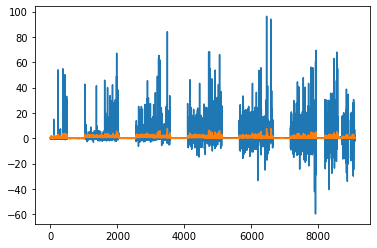

In [ ]:
print(np.mean(styles, 0).shape)
print(np.std(styles, 0).shape)
plt.plot(np.mean(styles, 0))
plt.plot(np.std(styles, 0))

In [ ]:
np.savetxt("exFace.txt", styles[4].astype(np.float32), fmt="%.10f", encoding = "utf8")

In [ ]:
np.savetxt("StdFace.txt", np.std(styles, 0).astype(np.float32), fmt="%.10f", encoding = "utf8")

In [ ]:
np.savetxt("MeanFace.txt", np.mean(styles, 0).astype(np.float32), fmt="%.10f", encoding = "utf8")

In [ ]:
np.savetxt("w_avg.txt", w_average.astype(np.float32), fmt="%.10f", encoding = "utf8")

In [ ]:
np.save('latents', latents)
np.save('styles', styles)

In [ ]:
latents = np.load('latents.npy', dtype=int)
styles = np.load('styles.npy', dtype=int)

In [ ]:
!pip install coremltools
import coremltools as ct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.7 MB/s 


In [ ]:
m = ct.convert(model)
m.save("approx.mlpackage")
!zip -r /content/approx.zip /content/approx.mlpackage

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 81/81 [00:00<00:00, 204.41 ops/s]


  adding: content/approx.mlpackage/ (stored 0%)
  adding: content/approx.mlpackage/Data/ (stored 0%)
  adding: content/approx.mlpackage/Data/com.apple.CoreML/ (stored 0%)
  adding: content/approx.mlpackage/Data/com.apple.CoreML/model.mlmodel (deflated 7%)
  adding: content/approx.mlpackage/Manifest.json (deflated 49%)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((512,)),
    generator.mapping_network
])
m = ct.convert(model)
m.save("mapping.mlpackage")
!zip -r /content/mapping.zip /content/mapping.mlpackage

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 69/69 [00:00<00:00, 120.21 ops/s]


  adding: content/mapping.mlpackage/ (stored 0%)
  adding: content/mapping.mlpackage/Data/ (stored 0%)
  adding: content/mapping.mlpackage/Data/com.apple.CoreML/ (stored 0%)
  adding: content/mapping.mlpackage/Data/com.apple.CoreML/model.mlmodel (deflated 7%)
  adding: content/mapping.mlpackage/Manifest.json (deflated 49%)
